In [37]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import pandas as pd
from glob import glob

In [38]:
# import zipfile

# #** unzip the folder GLEM_daily_dataset.zip **
# with zipfile.ZipFile("GLEM_daily_dataset.zip", "r") as zip_ref:
#     zip_ref.extractall("GLEM_daily_dataset")

# #** unzip the folder MADIA_daily_dataset_v1.3.zip **
# with zipfile.ZipFile("MADIA_daily_dataset_v1.3.zip", "r") as zip_ref:
#     zip_ref.extractall("MADIA_daily_dataset_v1.3")

In [ ]:
#** load the dataframe of climatological variables **

# load data from the csv files
csv_files = sorted(glob("./MADIA_daily_dataset_v1.3/csv_data/*_e5_d.csv"))
csv_files = [file for file in csv_files if 2018 <= int(file.split('/')[-1].split('_')[0]) <= 2022]

dailyClimatological_data = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)

    # keep only the data that are referred to the Piedmont region
    df_piedmont = df[df['latitude'].between(44.0, 46.5) & df['longitude'].between(6.5, 9.0)]
    
    global_dailyClimatological_data = pd.concat([dailyClimatological_data, df], ignore_index=True)
    dailyClimatological_data = pd.concat([dailyClimatological_data, df_piedmont], ignore_index=True)

print(dailyClimatological_data.head())

# tasmin    mean of daily minimum near-surface air temperature
# tasmean   mean of daily average near-surface air temperature
# tasmax    mean of daily maximum near-surface air temperature
# rhmin     mean of daily minimum near-surface relative air humidity
# rhmax     mean of daily maximum near-surface relative air humidity
# ws10      mean of daily wind speed
# ssrd      mean of daily surface solar radiation downwards (shortwave radiation)
# ppn       sum of daily depth of water-equivalent precipitation
# pev       sum of daily crop reference evapotranspiration estimated by FAO Penman-Monteith method
# zg        geopotential height: average cell height (metres) above the geoid, which corresponds approximately to the elevation
# dekad     number of dekad from the beginning of the year
# expver    code which identiﬁes temporary data when expver=5
# mask      boolean code to identify cells belonging to the Italian country

   longitude  latitude        time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0  2019-01-01 -1.882935  7.693695  2.905380  0.561286   
1       7.25      44.0  2019-01-02 -0.138916  9.710541  4.785812  0.303144   
2       7.25      44.0  2019-01-03 -2.536804  5.121948  1.292572  0.643776   
3       7.25      44.0  2019-01-04 -3.622375  3.283539 -0.169418  0.570179   
4       7.25      44.0  2019-01-05 -3.332275  7.154938  1.911331  0.360605   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  
0  0.847341  0.904585  5.053230  0.006468  0.449662     1.0   1.0  
1  0.819870  1.146744  5.525545  5.398749  0.686820     1.0   1.0  
2  0.896526  1.006395  5.724902  3.243667  0.366639     1.0   1.0  
3  0.878090  0.981817  4.451830  1.948434  0.424469     1.0   1.0  
4  0.662648  1.386134  7.364854  0.008526  0.647863     1.0   1.0  


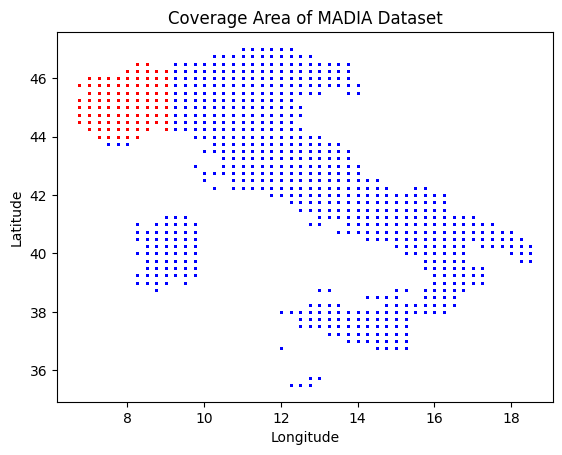

In [40]:
# **show a plot of the coverage area of the MADIA dataset **

# color in red the area of the Piedmont region
plt.scatter(global_dailyClimatological_data['longitude'], global_dailyClimatological_data['latitude'], s=1, c='blue', alpha=0.5)
plt.scatter(dailyClimatological_data['longitude'], dailyClimatological_data['latitude'], s=1, c='red', alpha=0.5)
plt.title('Coverage Area of MADIA Dataset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
#** load the dataset of Evapotranspiration from the nc file **

nc_files = sorted(glob("./GLEM_daily_dataset/E_*_GLEAM_v4.2a.nc"))
nc_files = [file for file in nc_files if 2018 <= int(file.split('/')[-1].split('_')[1]) <= 2022]

dailyE_data = []

for file in nc_files:
    ds = xr.open_dataset(file)

    # the evapotranspiration data are referenced to the Global territory
    E_lon = ds['lon'].values
    E_lat = ds['lat'].values

    # the climatological data are referenced to the Italian territory
    clim_lon = dailyClimatological_data['longitude'].values
    clim_lat = dailyClimatological_data['latitude'].values

    # select the evapotranspiration data for the Italian territory
    E_lon_idx = np.where((E_lon >= clim_lon.min()) & (E_lon <= clim_lon.max()))
    E_lat_idx = np.where((E_lat >= clim_lat.min()) & (E_lat <= clim_lat.max()))
    E_lon = E_lon[E_lon_idx]
    E_lat = E_lat[E_lat_idx]

    E_data = ds['E'].sel(lon=E_lon, lat=E_lat)
    dailyE_data.append(E_data)

dailyE_data = xr.concat(dailyE_data, dim='time')

/tmp/ipykernel_4950/1734681239.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis').copy()    # create a copy of the colormap


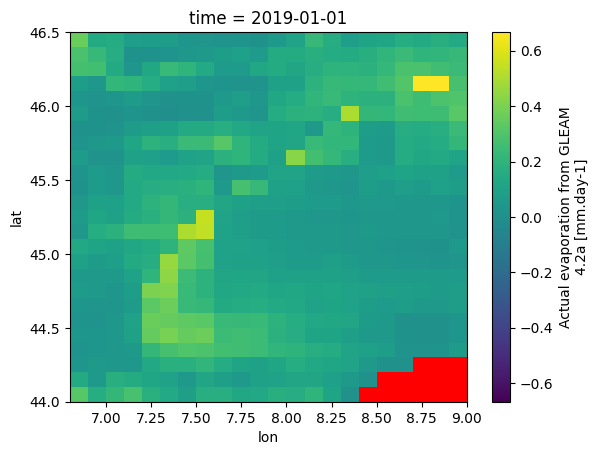

Daily Evapotranspiration shape (time, latitude, longitude): (1461, 25, 22)
Number of NaN values in the dataset: 14


In [42]:
#** show a plot of the Evapotranspiration data **

et = dailyE_data.isel(time=0)

cmap = cm.get_cmap('viridis').copy()    # create a copy of the colormap
cmap.set_bad(color='red')  # highlight NaN values in red

et.plot(cmap=cmap)  # plot the data with the modified colormap

plt.show()

print(f"Daily Evapotranspiration shape (time, latitude, longitude): {dailyE_data.shape}")

# count the number of pixel that are NaN at any time
nan_pixels = np.isnan(dailyE_data).any(dim='time').sum().item()
print(f"Number of NaN values in the dataset: {nan_pixels}")

In [43]:
#** evaluate the elapsed_days **

dailyClimatological_data['time'] = pd.to_datetime(dailyClimatological_data['time'])
dailyClimatological_data['elapsed_days'] = (dailyClimatological_data['time'] - dailyClimatological_data['time'].min()).dt.days.values
dailyClimatological_data['day_of_year'] = dailyClimatological_data['time'].dt.dayofyear.values

print(dailyClimatological_data.head())
print(dailyClimatological_data.tail())

   longitude  latitude       time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0 2019-01-01 -1.882935  7.693695  2.905380  0.561286   
1       7.25      44.0 2019-01-02 -0.138916  9.710541  4.785812  0.303144   
2       7.25      44.0 2019-01-03 -2.536804  5.121948  1.292572  0.643776   
3       7.25      44.0 2019-01-04 -3.622375  3.283539 -0.169418  0.570179   
4       7.25      44.0 2019-01-05 -3.332275  7.154938  1.911331  0.360605   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  \
0  0.847341  0.904585  5.053230  0.006468  0.449662     1.0   1.0   
1  0.819870  1.146744  5.525545  5.398749  0.686820     1.0   1.0   
2  0.896526  1.006395  5.724902  3.243667  0.366639     1.0   1.0   
3  0.878090  0.981817  4.451830  1.948434  0.424469     1.0   1.0   
4  0.662648  1.386134  7.364854  0.008526  0.647863     1.0   1.0   

   elapsed_days  day_of_year  
0             0            1  
1             1            2  
2             2            3 

In [44]:
#** associate the Evapotranspiration data to the climatological data **

# build a 2D grid of lat/lon points with the evapotranspiration data
grid_lat = dailyE_data['lat'].values
grid_lon = dailyE_data['lon'].values
grid_lon2d, grid_lat2d = np.meshgrid(grid_lon, grid_lat)

from scipy.spatial import cKDTree

# build a KDTree for fast nearest-neighbor search
grid_points = np.column_stack([grid_lat2d.ravel(), grid_lon2d.ravel()])
tree = cKDTree(grid_points)

# extract (lat, lon) from the climate data
query_points = dailyClimatological_data[['latitude', 'longitude']].values

# query the nearest grid points once
distances, indices = tree.query(query_points)

# convert flat indices to 2D (lat_idx, lon_idx)
lat_idx, lon_idx = np.unravel_index(indices, grid_lat2d.shape)

# time indices, evaluate the amount of days elapsed since the first day of the dataset
time_idx = dailyClimatological_data['elapsed_days']

# get values from xarray using vectorized indexing
E_values = dailyE_data.isel(
    time=xr.DataArray(time_idx, dims='points'),
    lat=xr.DataArray(lat_idx, dims='points'),
    lon=xr.DataArray(lon_idx, dims='points')
).values

# Assign to DataFrame
dailyClimatological_data['E'] = E_values

print(dailyClimatological_data.head())
print(dailyClimatological_data.tail())

print(f"Correction (degrees) - mean: {np.mean(distances):.6f}, min: {np.min(distances):.6f}, max: {np.max(distances):.6f}")

   longitude  latitude       time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0 2019-01-01 -1.882935  7.693695  2.905380  0.561286   
1       7.25      44.0 2019-01-02 -0.138916  9.710541  4.785812  0.303144   
2       7.25      44.0 2019-01-03 -2.536804  5.121948  1.292572  0.643776   
3       7.25      44.0 2019-01-04 -3.622375  3.283539 -0.169418  0.570179   
4       7.25      44.0 2019-01-05 -3.332275  7.154938  1.911331  0.360605   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  \
0  0.847341  0.904585  5.053230  0.006468  0.449662     1.0   1.0   
1  0.819870  1.146744  5.525545  5.398749  0.686820     1.0   1.0   
2  0.896526  1.006395  5.724902  3.243667  0.366639     1.0   1.0   
3  0.878090  0.981817  4.451830  1.948434  0.424469     1.0   1.0   
4  0.662648  1.386134  7.364854  0.008526  0.647863     1.0   1.0   

   elapsed_days  day_of_year         E  
0             0            1  0.182108  
1             1            2  0.642770  

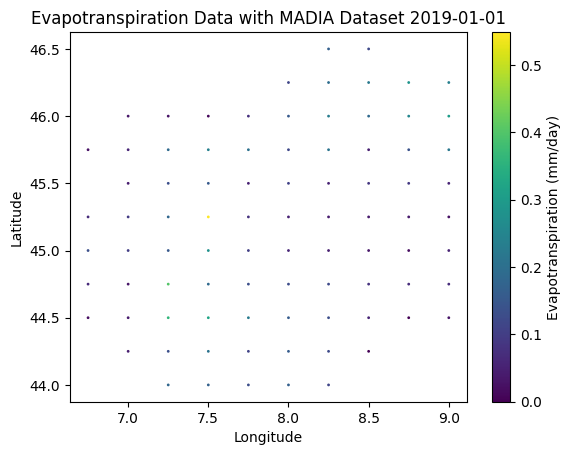

In [45]:
#** show a plot of the Evapotranspiration data with the MADIA dataset **

et = dailyClimatological_data[dailyClimatological_data['elapsed_days'] == 0]
plt.scatter(et['longitude'], et['latitude'], s=1, c=et['E'], cmap='viridis')
plt.colorbar(label='Evapotranspiration (mm/day)')
plt.title(f'Evapotranspiration Data with MADIA Dataset {et["time"].dt.strftime("%Y-%m-%d").values[0]}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [46]:
#** drop the rows with NaN values in the Evapotranspiration column **

print(f"Number of rows before dropping NaN values: {len(dailyClimatological_data)}")
dailyClimatological_data = dailyClimatological_data.dropna(subset=['E'])
print(f"Number of rows after dropping NaN values: {len(dailyClimatological_data)}")

Number of rows before dropping NaN values: 128568
Number of rows after dropping NaN values: 127107


In [47]:
#** print the fields of the dataframe **
print(dailyClimatological_data.columns)

Index(['longitude', 'latitude', 'time', 'tasmin', 'tasmax', 'tasmean', 'rhmin',
       'rhmax', 'ws10', 'ssrd', 'ppn', 'pev', 'expver', 'mask', 'elapsed_days',
       'day_of_year', 'E'],
      dtype='object')


In [48]:
#** apply normalization to the features **

from sklearn.preprocessing import StandardScaler

# normilize the features
features = ['day_of_year', 'tasmin', 'tasmean', 'tasmax', 'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn']
featureScaler = StandardScaler()
dailyClimatological_data[features] = featureScaler.fit_transform(dailyClimatological_data[features])

# normilize the target
target = 'E'
targetScaler = StandardScaler()
dailyClimatological_data[target] = targetScaler.fit_transform(dailyClimatological_data[[target]])

print(dailyClimatological_data.head())

   longitude  latitude       time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0 2019-01-01 -0.813904 -0.623385 -0.727229  0.066699   
1       7.25      44.0 2019-01-02 -0.619693 -0.411630 -0.520754 -1.360774   
2       7.25      44.0 2019-01-03 -0.886718 -0.893402 -0.904317  0.522852   
3       7.25      44.0 2019-01-04 -1.007606 -1.086424 -1.064846  0.115878   
4       7.25      44.0 2019-01-05 -0.975301 -0.679951 -0.836377 -1.043026   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  \
0 -0.280486 -0.738866 -1.229774 -0.436962  0.449662     1.0   1.0   
1 -0.532005 -0.432581 -1.167700  0.238499  0.686820     1.0   1.0   
2  0.169862 -0.610096 -1.141500 -0.031456  0.366639     1.0   1.0   
3  0.001059 -0.641181 -1.308812 -0.193703  0.424469     1.0   1.0   
4 -1.971558 -0.129798 -0.925971 -0.436704  0.647863     1.0   1.0   

   elapsed_days  day_of_year         E  
0             0    -1.727310 -1.034821  
1             1    -1.717826 -0.611959  

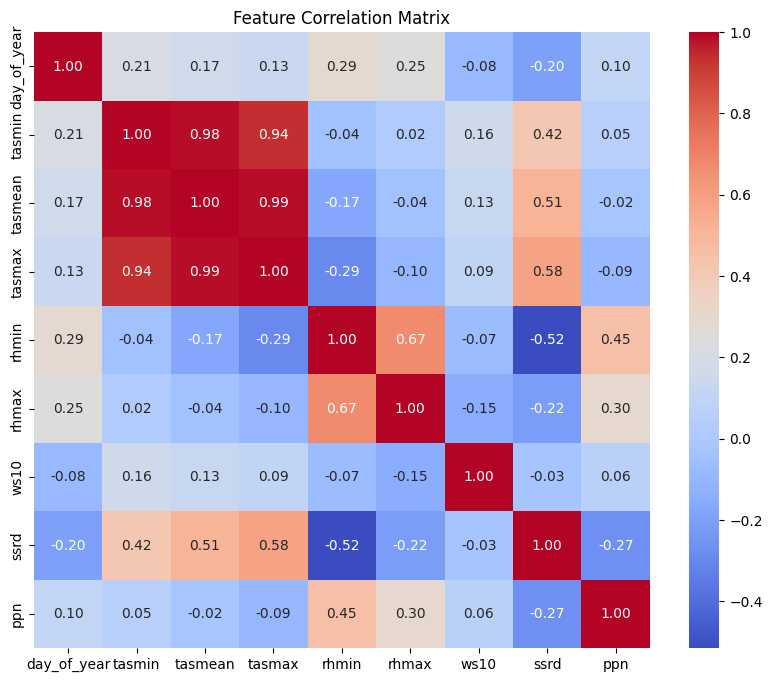

In [49]:
#** analyze the correlation between the features in the dataset **

import seaborn as sns

correlation_matrix = dailyClimatological_data[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Feature Correlation Matrix")
plt.show()

In [50]:
#** PCA for removing multicollinearity **

from sklearn.decomposition import PCA

# apply PCA
pca = PCA(n_components=0.95)  # retain 95% of variance
X_pca = pca.fit_transform(dailyClimatological_data[features])

print(f"Original number of features: {len(features)}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")

Original number of features: 9
Reduced number of features after PCA: 6


In [52]:
#** add longitude, latitude, elapsed_days and E to the PCA data **
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
X_pca_df['longitude'] = dailyClimatological_data['longitude'].values
X_pca_df['latitude'] = dailyClimatological_data['latitude'].values
X_pca_df['elapsed_days'] = dailyClimatological_data['elapsed_days'].values
X_pca_df['E'] = dailyClimatological_data['E'].values

print(X_pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6  longitude  \
0 -1.568100 -1.154612 -0.121940 -0.792894 -0.062943 -1.529411       7.25   
1 -0.900423 -1.644076  0.397511 -0.783410  0.717478 -1.049997       7.25   
2 -2.013405 -0.651476  0.037653 -1.106868 -0.205009 -1.232630       7.25   
3 -2.173826 -1.066770 -0.000126 -0.887066 -0.107952 -1.254409       7.25   
4 -1.038774 -2.697507  0.617057 -0.116392  0.834110 -1.240667       7.25   

   latitude  elapsed_days         E  
0      44.0             0 -1.034821  
1      44.0             1 -0.611959  
2      44.0             2 -0.838848  
3      44.0             3 -0.962764  
4      44.0             4 -0.956016  


**LSTM:**
- sequence lenght = 30
- features = ['day_of_year', 'tasmin', 'tasmean', 'tasmax', 'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn']
- loss = MSE
- optimizer = Adam
- batch size = 32
- stopping condition = early stopping with patience of 10 epochs (100 epochs max)

In [53]:
#** select random samples from the dataset **
 
# select half of the unique points in the dataset
n_samples = int(len(np.unique(X_pca_df[['longitude', 'latitude']])) / 2)
unique_locations = X_pca_df[['longitude', 'latitude']].drop_duplicates()

# sample n_samples unique locations
sampled_locations = unique_locations.sample(n=n_samples, random_state=42)

X_sequences = []
y_sequences = []

sequence_length = 30

for _, loc in sampled_locations.iterrows():
    loc_data = X_pca_df[
        (X_pca_df['longitude'] == loc['longitude']) &
        (X_pca_df['latitude'] == loc['latitude'])
    ].sort_values(by='elapsed_days')

    features = loc_data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']].values
    target = loc_data['E'].values
        
    for i in range(len(loc_data) - sequence_length):
        X_seq = features[i:i+sequence_length]
        y_val = target[i+sequence_length]
        X_sequences.append(X_seq)
        y_sequences.append(y_val)

X = np.array(X_sequences)
y = np.array(y_sequences)

In [54]:
#** build a dataset of shape (n_samples, n_features) **

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(X[0][:5])
print(y[0])

Feature matrix shape: (14310, 30, 6)
Target vector shape: (14310,)
[[-1.34515072 -2.61214262  1.29098482  0.04203903  0.33550439 -1.03730673]
 [-1.38520236 -2.97058002  1.77179161  0.39518261  0.73456999 -1.28952006]
 [-1.50768901 -3.61480944  1.70363559  0.52301812  1.12262715 -1.12273421]
 [-2.00868866 -3.09838814  1.31711705  0.18659449  0.60749206 -0.91859629]
 [-1.62925881 -3.07168312  2.1791809   0.5284051   0.53036701 -1.04555808]]
-0.8834491


In [55]:
#** mix the sequences of data **
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

print(f"Feature matrix shape after shuffle: {X.shape}")
print(f"Target vector shape after shuffle: {y.shape}")
print(X[0][:5])
print(y[0])

Feature matrix shape after shuffle: (14310, 30, 6)
Target vector shape after shuffle: (14310,)
[[ 0.77149701 -1.44808215 -0.4408397  -0.57074786  0.36689044 -0.43584596]
 [ 1.01254807 -1.3458727  -0.09663677 -0.522885    0.1270363  -0.29336255]
 [ 0.36272723 -0.69862938  0.22646718 -0.44888596 -0.23617458 -0.61694615]
 [ 0.46873498 -0.64452382 -0.29384837 -0.81856676 -0.4177405  -0.2414615 ]
 [-0.79301644  0.8636031   0.4943595  -0.966579    0.13783276 -1.02043951]]
0.8345943


In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (11448, 30, 6), (11448,)
Testing set shape: (2862, 30, 6), (2862,)


In [57]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

# the model learns to predict the next day ET value based on the previous 30 days of data

model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(sequence_length, 6)))  # input shape (sequence_length, n_features)
model.add(tf.keras.layers.LSTM(128, return_sequences=True))   # return_sequences=True, each of the LSTM cells returns its sequence of 128 outputs. So the output shape is (batch_size, sequence_length, 128)

model.add(tf.keras.layers.LSTM(64, return_sequences=False)) # return_sequences=False, the last LSTM cell returns its last output. So the output shape is (batch_size, 64)
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(1))  # predict a single ET value

# compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

2025-05-20 09:03:37.634540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 09:03:37.781344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747724617.845552    4950 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747724617.863701    4950 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747724617.981654    4950 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1747724621.811255    4950 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1722 MB memory:  -> device: 0, name: NVIDIA GeForce MX350, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,753 (479.50 KB)

 Trainable params: 122,753 (479.50 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# i am feeding the NN with 32 sequences at a time (batch size). Each of these sequences is made by 30 days of data, each data is made by 8 features
# I have 14310 * 0.8 due to train and test set split, these sequences are divided in batches of 32 and with a validation split of 0.2, means that the number of iterations needed to complete each epoch is 14310 * 0.8 * 0.8 / 32 = 286.2

# use EarlyStopping to train until convergence (no improvement in validation loss for 5 epochs)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.0001)
# history = model.fit(
#     X_train, y_train,
#     batch_size=32,
#     validation_split=0.2,
#     epochs=100,  # set a high max epoch, training will stop early if converged
#     callbacks=[early_stopping]
# )
history = model.fit(
    X_train, y_train,
    batch_size=32,
    validation_split=0.2,
    epochs=50,
)

Epoch 1/50


I0000 00:00:1747724631.695509   12440 cuda_dnn.cc:529] Loaded cuDNN version 90501


287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.2529 - val_loss: 0.1424
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1563 - val_loss: 0.1369
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1456 - val_loss: 0.1372
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1298 - val_loss: 0.1323
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1328 - val_loss: 0.1141
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1306 - val_loss: 0.1097
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1266 - val_loss: 0.1023
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1102 - val_loss: 0.1097
Epoch 9/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1184 - val_loss: 0.1175
Epoch 10/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1124 - val_loss: 0.1021
Epoch 11/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1039 - val_loss: 0.0994
Epoch 12/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/st

In [59]:
#** test the model on the test set **
y_pred = model.predict(X_test)

# invert the normalization of the predicted values
y_pred_rescaled = targetScaler.inverse_transform(y_pred)
y_test_rescaled = targetScaler.inverse_transform(y_test.reshape(-1, 1))

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [60]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f"R2 score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

R2 score: 0.8974
MAPE: 0.4233


In [61]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true) / (denominator + 1e-8)
    return 100 * np.mean(diff)

smape = symmetric_mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f"SMAPE: {smape:.4f}")

SMAPE: 24.1144


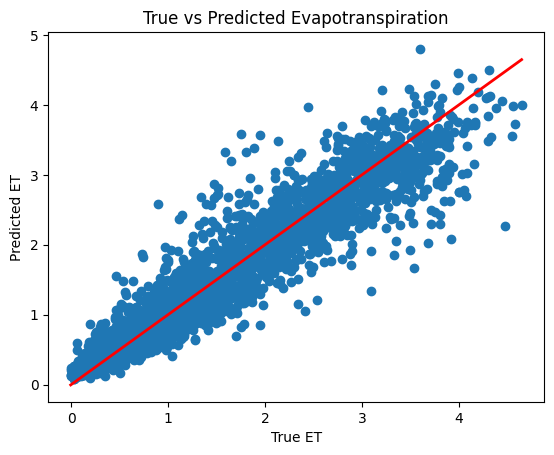

In [63]:
#**  see a plot of the accuracy of the predictions **
plt.scatter(y_test_rescaled, y_pred_rescaled)
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', lw=2)  # Identity line
plt.xlabel('True ET')
plt.ylabel('Predicted ET')
plt.title('True vs Predicted Evapotranspiration')
plt.show()

**LSTM:**
- sequence lenght = 30
- features = ['day_of_year', 'tasmin', 'tasmean', 'tasmax', 'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn']
- loss = Huber
- optimizer = Adam
- batch size = 32
- stopping condition = early stopping with patience of 10 epochs (100 epochs max)

In [64]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

# the model learns to predict the next day ET value based on the previous 30 days of data

model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(sequence_length, 6)))  # input shape (sequence_length, n_features)
model.add(tf.keras.layers.LSTM(128, return_sequences=True))   # return_sequences=True, each of the LSTM cells returns its sequence of 128 outputs. So the output shape is (batch_size, sequence_length, 128)

model.add(tf.keras.layers.LSTM(64, return_sequences=False)) # return_sequences=False, the last LSTM cell returns its last output. So the output shape is (batch_size, 64)
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(1))  # predict a single ET value

huber_loss = tf.keras.losses.Huber(delta=1.0)

model.compile(optimizer='adam', loss=huber_loss)
model.summary()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,753 (479.50 KB)

 Trainable params: 122,753 (479.50 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# i am feeding the NN with 32 sequences at a time (batch size). Each of these sequences is made by 30 days of data, each data is made by 8 features
# I have 14310 * 0.8 due to train and test set split, these sequences are divided in batches of 32 and with a validation split of 0.2, means that the number of iterations needed to complete each epoch is 14310 * 0.8 * 0.8 / 32 = 286.2

# use EarlyStopping to train until convergence (no improvement in validation loss for 5 epochs)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.0001)
# history = model.fit(
#     X_train, y_train,
#     batch_size=32,
#     validation_split=0.2,
#     epochs=100,  # set a high max epoch, training will stop early if converged
#     callbacks=[early_stopping]
# )
history = model.fit(
    X_train, y_train,
    batch_size=32,
    validation_split=0.2,
    epochs=50,
)

Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1162 - val_loss: 0.0709
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0760 - val_loss: 0.0699
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0709 - val_loss: 0.0599
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0684 - val_loss: 0.0670
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0662 - val_loss: 0.0582
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0598 - val_loss: 0.0532
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0582 - val_loss: 0.0512
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0583 - val_loss: 0.0523
Epoch 9/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0549 - val_loss: 0.0512
Epoch 10/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0513 - val_loss: 0.0502
Epoch 11/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0520 - val_loss: 0.0486
Epoch 12/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 

In [66]:
#** test the model on the test set **
y_pred = model.predict(X_test)

# invert the normalization of the predicted values
y_pred_rescaled = targetScaler.inverse_transform(y_pred)
y_test_rescaled = targetScaler.inverse_transform(y_test.reshape(-1, 1))

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [67]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f"R2 score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

R2 score: 0.9021
MAPE: 0.3360


In [68]:
smape = symmetric_mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f"SMAPE: {smape:.4f}")

SMAPE: 23.1943


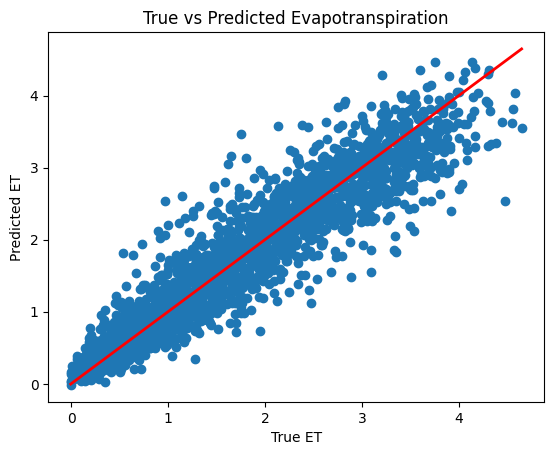

In [69]:
#**  see a plot of the accuracy of the predictions **
plt.scatter(y_test_rescaled, y_pred_rescaled)
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', lw=2)  # Identity line
plt.xlabel('True ET')
plt.ylabel('Predicted ET')
plt.title('True vs Predicted Evapotranspiration')
plt.show()